<a href="https://colab.research.google.com/github/seanpaz478/USDAAI521Team1FinalProject/blob/main/AAI_521FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Importing necessary libraries
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision.transforms.functional import normalize
from torchvision.utils import make_grid
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [2]:
# Checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Loading and preprocessing the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder('new_lung_colon_image_set', transform=transform)

# Splitting into train, val, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

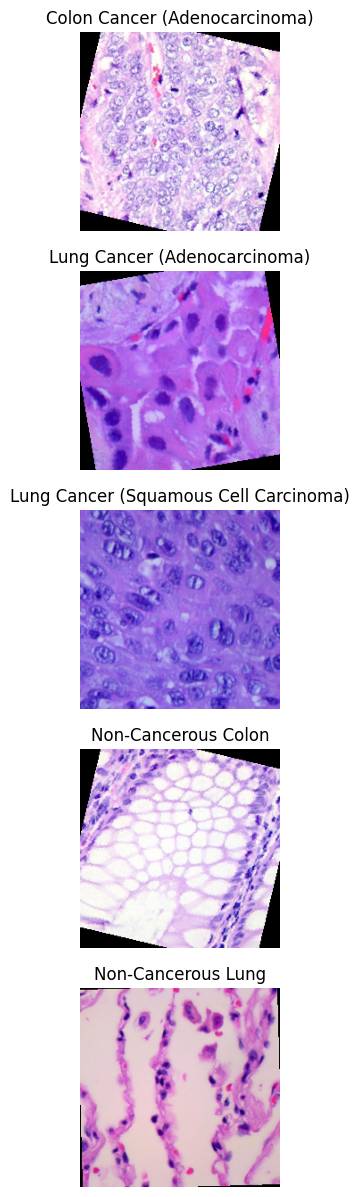

In [4]:
# Displaying images of dataset from both classes
def imshow(img, label):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.axis('off')

def display_class_samples(data, num_samples):
    class_names = {0: "Colon Cancer (Adenocarcinoma)", 
                   1: "Lung Cancer (Adenocarcinoma)", 
                   2: "Lung Cancer (Squamous Cell Carcinoma)",
                   3: "Non-Cancerous Colon",
                   4: "Non-Cancerous Lung"}
    samples = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Collecting samples of each class
    for img, label in data:
        if len(samples[0]) < num_samples and label == 0:
            samples[0].append((img, label))
        elif len(samples[1]) < num_samples and label == 1:
            samples[1].append((img, label))
        elif len(samples[2]) < num_samples and label == 2:
            samples[2].append((img, label))
        elif len(samples[3]) < num_samples and label == 3:
            samples[3].append((img, label))
        elif len(samples[4]) < num_samples and label == 4:
            samples[4].append((img, label))
        if len(samples[0]) >= num_samples and len(samples[1]) >= num_samples and len(samples[2]) >= num_samples and len(samples[3]) >= num_samples and len(samples[4]) >= num_samples:
            break

    # Combining the samples
    all_samples = samples[0] + samples[1] + samples[2] + samples[3] + samples[4]
    plt.figure(figsize=(15, 15))
    for i, (img, label) in enumerate(all_samples):
        plt.subplot(5, num_samples, i + 1)
        imshow(img, class_names[label])
    plt.show()

# Showing samples of cancerous vs non-cancerous cells
display_class_samples(dataset, 1)

In [5]:
# Using MobileNet pre-trained model as the base
model = mobilenet_v2(pretrained=True)

# Modifying classifier
num_features = model.last_channel
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 5),
    nn.Softmax(dim=1)
)

# Defining values for model training
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-4)
num_epochs = 50

model = model.to(device)

C:\Users\seanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\seanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Implementing early stopping class to end training early if there are no improvements to validation loss
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=1e-2):
        """
        Args:
            patience (int): Number of epochs to wait after the last improvement.
            verbose (bool): If True, prints messages when early stopping is triggered.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_acc, model, epoch):
        score = val_acc  

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model, epoch)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, epoch):
        #Saves the model when validation loss decreases
        if self.verbose:
            print(f"Validation accuracy improved to {val_acc:.2f}%. Saving model...")
        
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch' : epoch
        }

        torch.save(checkpoint, "checkpoint.pth")

Epoch 1/50 | Train Loss: 0.965267, Train Acc: 94.66% | Val Loss: 0.922673, Val Acc: 98.35%
Validation accuracy improved to 98.35%. Saving model...
Epoch 2/50 | Train Loss: 0.929715, Train Acc: 97.74% | Val Loss: 0.913103, Val Acc: 99.25%
Validation accuracy improved to 99.25%. Saving model...
Epoch 3/50 | Train Loss: 0.921119, Train Acc: 98.53% | Val Loss: 0.909184, Val Acc: 99.60%
Validation accuracy improved to 99.60%. Saving model...
Epoch 4/50 | Train Loss: 0.915866, Train Acc: 99.04% | Val Loss: 0.909151, Val Acc: 99.65%
Validation accuracy improved to 99.65%. Saving model...
Epoch 5/50 | Train Loss: 0.914037, Train Acc: 99.19% | Val Loss: 0.908879, Val Acc: 99.63%
EarlyStopping counter: 1 out of 2
Epoch 6/50 | Train Loss: 0.914445, Train Acc: 99.10% | Val Loss: 0.911203, Val Acc: 99.39%
EarlyStopping counter: 2 out of 2
Early stopping triggered!


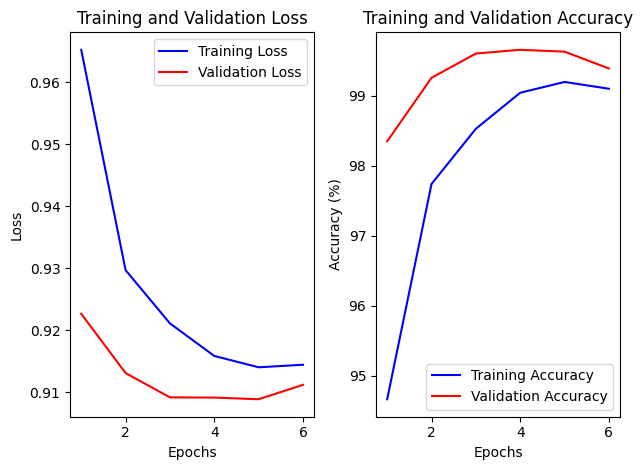

In [7]:
# Training loop
early_stopping = EarlyStopping(patience=2, verbose=True)
train_losses = []
val_losses = []
train_accs = []
val_accs = []
start_epoch = 0

# Loading and resuming training from checkpoint if it exists
if(os.path.exists('checkpoint.pth')):
    checkpoint = torch.load('checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f'Resuming training from epoch {start_epoch + 1}')

for epoch in range(num_epochs - start_epoch):
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)


    print(f"Epoch {start_epoch + epoch + 1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.6f}, "
          f"Train Acc: {train_acc:.2f}% | Val Loss: {val_loss/len(val_loader):.6f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    early_stopping(val_acc, model, start_epoch + epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(train_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', color='blue')
plt.plot(range(1, len(train_accs) + 1), val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Using Grad-CAM to visualize regions of the image that contribute the most to the model's predictions
def grad_cam(model, image, target_class, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Containers for gradients and activations
    gradients = {'values': []}
    activations = {'values': []}

    def save_gradient(module, grad_in, grad_out):
        gradients['values'].append(grad_out[0]) 

    def save_activation(module, input, output):
        activations['values'].append(output)

    # Hooking to the last convolutional layer
    target_layer = model.features[-1] 
    forward_handle = target_layer.register_forward_hook(save_activation)
    backward_handle = target_layer.register_backward_hook(save_gradient)

    try:
        # Forward pass
        output = model(image)
        class_idx = target_class if target_class is not None else output.argmax(1).item()

        # Backward pass
        model.zero_grad()
        output[0, class_idx].backward()

        # Validating activations and gradients
        if not activations or not gradients:
            raise RuntimeError("Hooks failed to capture activations or gradients.")

        # Processing activations and gradients
        activations_array = activations['values'][0].detach().cpu().numpy()[0]
        gradients_array = gradients['values'][0].detach().cpu().numpy()[0]

        # Computing weights and Grad-CAM
        weights = np.mean(gradients_array, axis=(1, 2))
        cam = np.sum(weights[:, None, None] * activations_array, axis=0)

        # Normalizing and upscaling heatmap
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam / cam.max()

        return cam

    finally:
        # Removing hooks to prevent memory issues
        forward_handle.remove()
        backward_handle.remove()

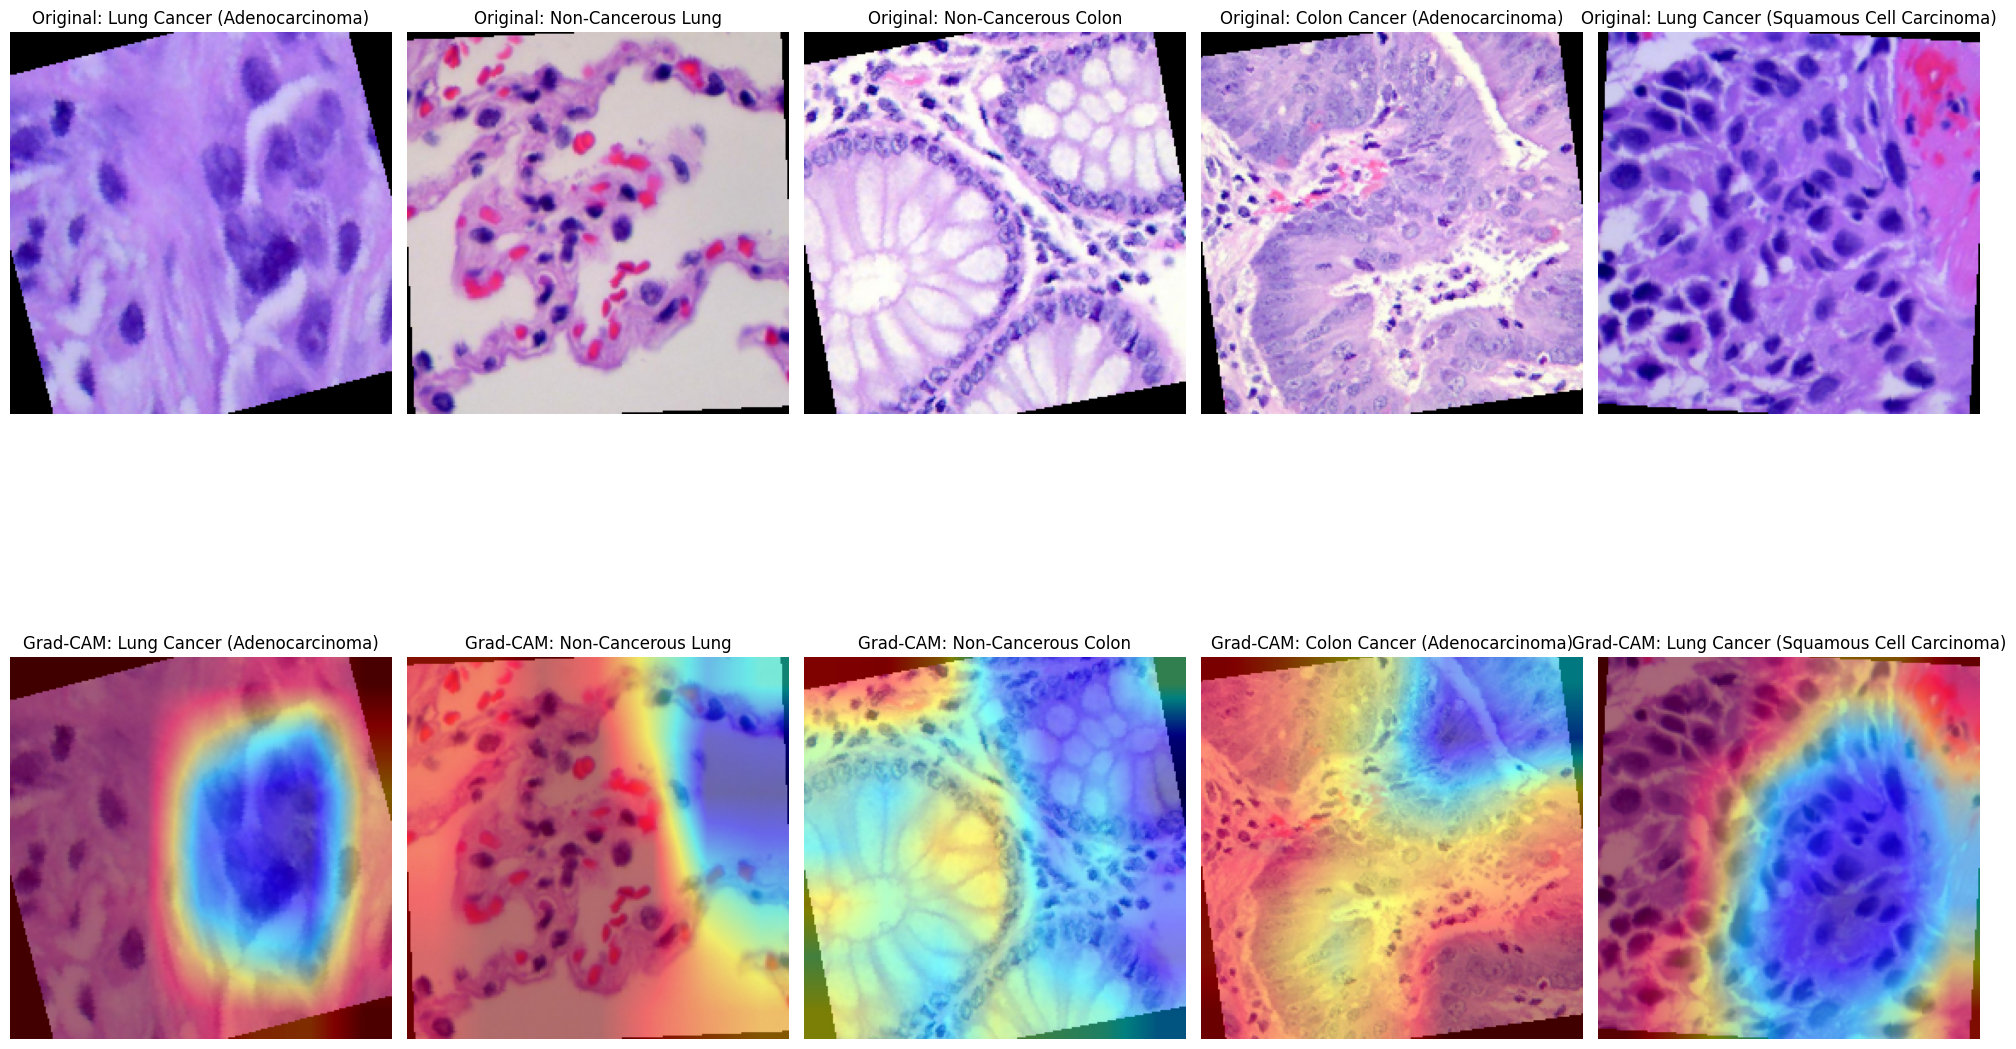

In [ ]:
# Displaying original image and Grad-CAM overlay for a sample from each class

# Mapping class indices to names
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

def get_one_sample_per_class(test_set):
    class_samples = {}
    for img, label in test_set:
        if label not in class_samples:
            class_samples[label] = img
        if len(class_samples) == len(test_set.dataset.classes):
            break
    return class_samples

def visualize_samples_with_grad_cam(model, class_samples, grad_cam_func, device):
    model.eval()
    plt.figure(figsize=(20, 15))

    for i, (label, image_tensor) in enumerate(class_samples.items()):
        # Generating Grad-CAM mask
        grad_cam_mask = grad_cam_func(model, image_tensor, target_class=label, device=device)
        
        # Normalizing image for display
        image = image_tensor.permute(1, 2, 0).numpy()  
        image = (image - image.min()) / (image.max() - image.min())  
        
        # Overlaying Grad-CAM heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        overlay = heatmap + np.float32(image)
        overlay = overlay / overlay.max()
        
        # Displaying the original image and Grad-CAM overlay
        plt.subplot(2, len(class_samples), i + 1)
        plt.imshow(image)
        plt.title(f"Original: {idx_to_class[label]}")
        plt.axis('off')
        
        plt.subplot(2, len(class_samples), i + 1 + len(class_samples))
        plt.imshow(overlay)
        plt.title(f"Grad-CAM: {idx_to_class[label]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Getting one sample per class
class_samples = get_one_sample_per_class(test_set)

# Visualizing the samples with Grad-CAM
visualize_samples_with_grad_cam(model, class_samples, grad_cam, device)

C:\Users\seanp\AppData\Local\Temp\ipykernel_17636\1659718793.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       763
           1       0.99      0.99      0.99       736
           2       0.99      0.99      0.99       784
           3       1.00      1.00      1.00       716
           4       1.00      1.00      1.00       751

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750



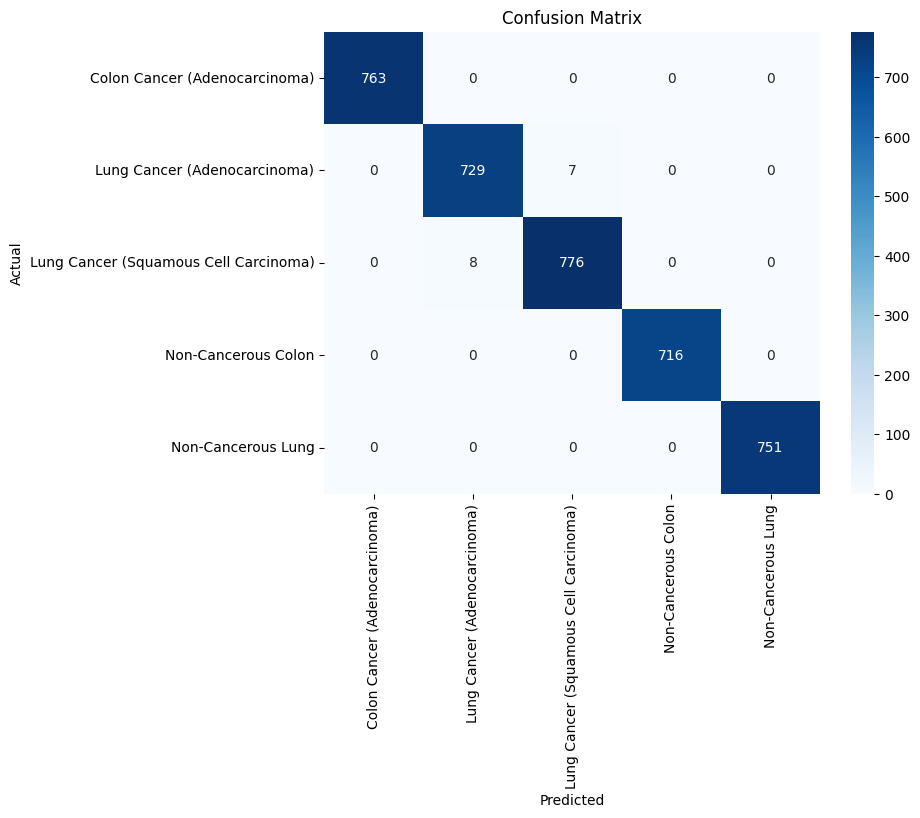

In [ ]:
# Adding precision, recall, F1-score, and confusion matrix
# Function to evaluate on a dataset
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Loading best model from checkpoint
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

evaluate_model(model, test_loader)